In [ ]:
import os
import numpy as np 
import pandas as pd 
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [ ]:
from zipfile import ZipFile
ZipFile("/content/drive/MyDrive/Project_CE434/Car_moto_vgg16/test1.zip","r").extractall()
ZipFile("/content/drive/MyDrive/Project_CE434/Car_moto_vgg16/training1.zip", "r").extractall()
ZipFile("/content/drive/MyDrive/Project_CE434/Car_moto_vgg16/validate1.zip", "r").extractall()

In [ ]:
TRAIN_PATH = './training1'
TEST_PATH = './test1'
VALID_PATH = './validate1'
MODELS_PATH = '/content/drive/MyDrive/Project_CE434/Car_moto_vgg16/model/'
VISUALIZE_PATH = '/content/drive/MyDrive/Project_CE434/Car_moto_vgg16/visualize/'
WIDTH = 224
HEIGHT = 224
EPOCHS = 20
BATCH_SIZE = 32

In [ ]:
from tensorflow.keras.preprocessing import image
train_generator = image.ImageDataGenerator(
    rescale = 1./255,  
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 15
)
test_generator = image.ImageDataGenerator(
    rescale = 1./255,    
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 15
)
valid_generator = image.ImageDataGenerator(
    rescale = 1./255,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    zoom_range = 0.2,
    rotation_range = 15
)

In [ ]:
generated_train_data = train_generator.flow_from_directory(
    TRAIN_PATH,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True, 
    seed=42
)

Found 2000 images belonging to 2 classes.


In [ ]:
generated_valid_data = valid_generator.flow_from_directory(
    VALID_PATH,
    target_size = (WIDTH, HEIGHT),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed=42
)

Found 360 images belonging to 2 classes.


In [ ]:
generated_test_data = test_generator.flow_from_directory(
    TEST_PATH,
    target_size = (WIDTH, HEIGHT),
    class_mode = 'categorical',
    shuffle = False,
)

Found 500 images belonging to 2 classes.


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
pre_trained_model = VGG16(input_shape = (WIDTH, HEIGHT, 3), include_top = False, weights = 'imagenet')

In [ ]:
# Dong bang cac layer
for layer in pre_trained_model.layers:
      layer.trainable = False

# Tao model
input = Input(shape=(WIDTH, HEIGHT, 3), name='image_input')
output_vgg16_conv = pre_trained_model(input)

# Them cac layer FC va Dropout
x = Flatten(name='flatten')(output_vgg16_conv)
x = Dense(4096, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(4096, activation='relu', name='fc2')(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='softmax', name='predictions')(x)

In [ ]:
# Compile
from tensorflow.keras.optimizers import Adam
my_model = Model(inputs=input, outputs=x)
my_model.compile(optimizer = Adam(lr = 1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
vgg16_history = my_model.fit(
    generated_train_data, 
    validation_data = generated_valid_data,
    validation_steps = generated_valid_data.n // BATCH_SIZE,
    steps_per_epoch = generated_train_data.n  // BATCH_SIZE,
    epochs = EPOCHS,
    verbose = 1
)
my_model.save(MODELS_PATH + 'vgg16.h5')

Epoch 1/20
62/62 [==============================] - 75s 894ms/step - loss: 0.5899 - accuracy: 0.6919 - val_loss: 0.0958 - val_accuracy: 0.9744
Epoch 2/20
62/62 [==============================] - 51s 816ms/step - loss: 0.1764 - accuracy: 0.9394 - val_loss: 0.0425 - val_accuracy: 0.9943
Epoch 3/20
62/62 [==============================] - 51s 814ms/step - loss: 0.1282 - accuracy: 0.9519 - val_loss: 0.0355 - val_accuracy: 0.9915
Epoch 4/20
62/62 [==============================] - 51s 821ms/step - loss: 0.0959 - accuracy: 0.9674 - val_loss: 0.0247 - val_accuracy: 0.9886
Epoch 5/20
62/62 [==============================] - 52s 831ms/step - loss: 0.0755 - accuracy: 0.9724 - val_loss: 0.0219 - val_accuracy: 0.9915
Epoch 6/20
62/62 [==============================] - 52s 832ms/step - loss: 0.0634 - accuracy: 0.9730 - val_loss: 0.0160 - val_accuracy: 0.9972
Epoch 7/20
62/62 [==============================] - 51s 829ms/step - loss: 0.0464 - accuracy: 0.9837 - val_loss: 0.0112 - val_accuracy: 0.9972

In [ ]:
y_test = generated_test_data.classes
y_pred_vgg16 = my_model.predict(generated_test_data, verbose = 1)

16/16 [==============================] - 20s 1s/step


In [ ]:
generated_train_data.class_indices.items()

dict_items([('car', 0), ('moto', 1)])

In [ ]:
df = pd.DataFrame({
    'Actual'     : generated_test_data.filenames, 
    'VGG16 prediction' : np.argmax(y_pred_vgg16, axis=1)
})  
df.head(20)

,Actual,VGG16 prediction
0,car/car.1.jpg,0
1,car/car.10.jpg,0
2,car/car.100.jpg,0
3,car/car.101.jpg,0
4,car/car.102.jpg,0
5,car/car.103.jpg,0
6,car/car.104.jpg,0
7,car/car.105.jpg,0
8,car/car.106.jpg,0
9,car/car.107.jpg,0


In [ ]:
df.tail(20)

,Actual,VGG16 prediction
480,moto/moto.81.jpg,1
481,moto/moto.82.jpg,1
482,moto/moto.83.jpg,1
483,moto/moto.84.jpg,1
484,moto/moto.85.jpg,1
485,moto/moto.86.jpg,1
486,moto/moto.87.jpg,1
487,moto/moto.88.jpg,1
488,moto/moto.89.jpg,1
489,moto/moto.9.jpg,1


In [ ]:
def plot_history(history, model_name = ''):

    fig, axes = plt.subplots(1, 2, figsize = (15, 5))
    
    axes[0].plot(history.history['accuracy'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Train')
    axes[0].plot(history.history['val_accuracy'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Test')
    axes[0].set_xlabel('Epochs', fontsize = 14)
    axes[0].set_ylabel('Accuracy',fontsize = 14)
    axes[0].set_title(model_name + ' accuracy', fontsize = 14)
    axes[0].legend(loc = 'best')
    
    axes[1].plot(history.history['loss'], linestyle = 'solid', marker = 'o', color = 'crimson', label = 'Train')
    axes[1].plot(history.history['val_loss'], linestyle = 'solid', marker = 'o', color = 'dodgerblue', label = 'Test')
    axes[1].set_xlabel('Epochs', fontsize = 14)
    axes[1].set_ylabel('Loss',fontsize = 14)
    axes[1].set_title(model_name + ' loss', fontsize = 14)
    axes[1].legend(loc = 'best')
    
    fig.savefig(VISUALIZE_PATH + model_name + ' evaluation.png', bbox_inches = 'tight') 
    plt.show()

FileNotFoundError: ignored

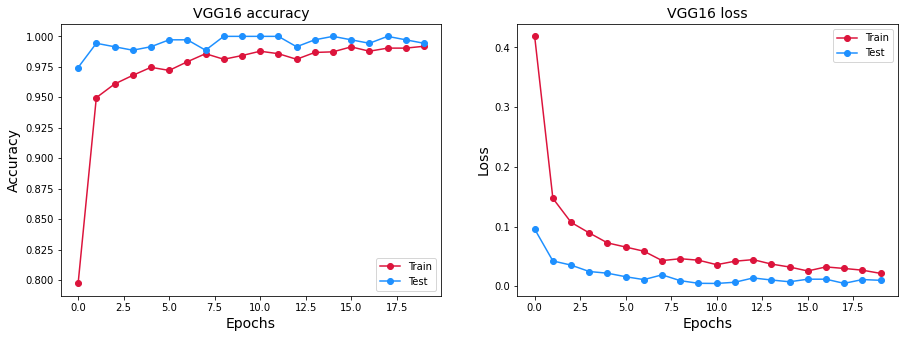

In [ ]:
plot_history(vgg16_history, 'VGG16')


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

cf_matrix_vgg16 = confusion_matrix(y_test, np.argmax(y_pred_vgg16, axis=1))
print(classification_report(y_test, np.argmax(y_pred_vgg16, axis=1)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       250
           1       1.00      0.99      0.99       250

    accuracy                           0.99       500
   macro avg       0.99      0.99      0.99       500
weighted avg       0.99      0.99      0.99       500



In [ ]:
img_test = image.load_img('/content/drive/MyDrive/Project_CE434/image_test/car_vinfast.jpg', target_size = (WIDTH, HEIGHT))
img_test = image.img_to_array(img_test) / 255
img_test = np.expand_dims(img_test, axis = 0)
img_test.shape

(1, 224, 224, 3)

In [ ]:
vgg16_model = tf.keras.models.load_model(MODELS_PATH + 'vgg16.h5')
classes = my_model.predict(img_test)

if np.argmax(classes, axis=1) == 1:
  print('moto')
else:
  print('car')

car


In [ ]:
img_test_1 = image.load_img('/content/drive/MyDrive/Project_CE434/image_test/honda_winerx.jpg', target_size = (WIDTH, HEIGHT))
img_test_1 = image.img_to_array(img_test_1) / 255
img_test_1 = np.expand_dims(img_test_1, axis = 0)
img_test_1.shape

(1, 224, 224, 3)

In [ ]:
vgg16_model = tf.keras.models.load_model(MODELS_PATH + 'vgg16.h5')
classes = my_model.predict(img_test_1)

if np.argmax(classes, axis=1) == 1:
  print('moto')
else:
  print('car')

moto
